In [ ]:
import numpy as np
import pandas as pd
import random
import h5py
import torch
import torch.nn as nn
from torch.utils.data import Dataset, Sampler, DataLoader
import numpy as np
from torch.utils.data import DataLoader, Sampler
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.utils import make_grid

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
from pathlib import Path

# Define the project path
PROJECT_PATH = Path('/content/drive/MyDrive/AutomaticHeartSoundClassification-main')
sys.path.append(str(PROJECT_PATH))

# Define the dataset path
DATASET_PATH = Path('/content/drive/MyDrive/AutomaticHeartSoundClassification-main/data')
sys.path.append(str(DATASET_PATH))

# Load Data

## HeartSoundDataSet

In [ ]:
import numpy as np
import h5py
import random
import torch
from pathlib import Path
import librosa  # cần import để tính delta

EPS = 1e-8

def standard_normal_variate(data):
    """Chuẩn hóa Z-score trên toàn bộ tensor."""
    mean = np.mean(data)
    std = np.std(data) + EPS
    return (data - mean) / std

class HeartSoundDataSet(torch.utils.data.Dataset):
    def __init__(self,
                 fea_path: str,              # đường dẫn file .h5
                 labels: pd.DataFrame,       # DataFrame với cột 'filename' và 'label'
                 duration: int = 5,          # giây
                 training: bool = True,
                 delta: bool = False,
                 norm: bool = True):
        self._fea_path = fea_path
        self._h5database = None
        self._labels = labels.reset_index(drop=True)
        self._colname = ['filename', 'label']
        self._len = len(self._labels)
        self._duration = duration
        self._delta = delta
        self.train = training
        self.hop_length = 15  # ms
        self.norm = norm

    def __len__(self):
        return self._len

    def __getitem__(self, idx):
      row = self._labels.iloc[idx]
      filename = row['filename']
      target_bin = row['label']

      # Lấy key từ stem của filename
      key = Path(filename).stem if '/' in str(filename) else filename

      # Mở HDF5 nếu chưa mở
      if self._h5database is None:
          self._h5database = h5py.File(self._fea_path, 'r')

      if key not in self._h5database:
          available = list(self._h5database.keys())[:10]
          raise KeyError(f"Key '{key}' not found in HDF5. Sample keys: {available}")

      # Load feature từ HDF5
      feature = self._h5database[key][()]  # (mel_bins, T) hoặc (C, mel_bins, T)

      # Đảm bảo feature là 3D: (C, H, W)
      if feature.ndim == 2:
          feature = feature[np.newaxis, :, :]  # → (1, mel_bins, T)
      elif feature.ndim != 3:
          raise ValueError(f"Unexpected shape {feature.shape} for key '{key}'")

      # Chuẩn hóa toàn bộ tensor (nếu bật)
      if self.norm:
          feature = standard_normal_variate(feature)

      # Thêm delta features (nếu bật)
      if self._delta:
          orig = feature[0]  # (mel_bins, T)
          delta = librosa.feature.delta(orig)
          delta2 = librosa.feature.delta(delta)
          feature = np.stack([orig, delta, delta2], axis=0)  # → (3, mel_bins, T)

      # Lấy shape hiện tại
      channels, mel_bins, num_frames = feature.shape

      # Tính độ dài mong muốn (frames)
      cycle_len = int(self._duration * 1000 / self.hop_length)

      # Crop hoặc pad để đạt đúng cycle_len
      if num_frames >= cycle_len:
          if self.train:
              start_ind = random.randint(0, num_frames - cycle_len)
          else:
              start_ind = (num_frames - cycle_len) // 2
          feature = feature[:, :, start_ind:start_ind + cycle_len]
      elif num_frames < cycle_len:
          pad_width = ((0, 0), (0, 0), (0, cycle_len - num_frames))
          feature = np.pad(feature, pad_width, mode='wrap')

      # === Fix quan trọng cho model gốc: Làm cho tensor luôn là 3D (mel_bins, num_frames) ===
      feature_tensor = torch.from_numpy(feature).float()  # (C, mel_bins, T)

      if channels > 1:  # Có delta → C=3
          # Ghép 3 channels vào chiều mel_bins → (3 * mel_bins, T) = (384, T)
          # Model sẽ view thành (B, 3, 128, T) trong forward
          feature_tensor = feature_tensor.view(channels * mel_bins, -1)  # → (384, T)
      else:
          # Không delta → squeeze về (mel_bins, T) = (128, T)
          feature_tensor = feature_tensor.squeeze(0)

      return feature_tensor, torch.tensor(target_bin, dtype=torch.long)

    def __del__(self):
        """Đóng file HDF5 khi object bị hủy (tốt cho quản lý tài nguyên)."""
        if self._h5database is not None:
            self._h5database.close()

## MinimumOccupancySampler

In [ ]:
class MinimumOccupancySampler(Sampler):
    """
        samples at least one instance from each class sequentially
    """
    def __init__(self, labels, sampling_mode='over', random_state=None):
        data_samples = labels.shape
        n_labels = len(np.unique(labels))
        label_to_idx_list, label_to_length = [], []
        self.random_state = np.random.RandomState(seed=random_state)
        for lb_idx in range(n_labels):
            label_indexes = np.where(labels == lb_idx)[0]
            self.random_state.shuffle(label_indexes)
            label_to_length.append(len(label_indexes))
            label_to_idx_list.append(label_indexes)

        self.longest_seq = max(label_to_length)
        self.data_source = np.empty((self.longest_seq, len(label_to_length)), dtype=int)
        # Each column represents one "single instance per class" data piece
        for ix, leng in enumerate(label_to_length):
            self.data_source[:leng, ix] = label_to_idx_list[ix]
        self.label_to_length = label_to_length
        self.label_to_idx_list = label_to_idx_list

        if sampling_mode == 'same':
            self.data_length = data_samples
        elif sampling_mode == 'over':  # Sample all items
            self.data_length = np.prod(self.data_source.shape)

    def _resample(self):
        for ix, leng in enumerate(self.label_to_length):
            leftover = self.longest_seq - leng
            random_idxs = np.random.randint(leng, size=leftover)
            self.data_source[leng:, ix] = self.label_to_idx_list[ix][random_idxs]

    def __iter__(self):
        self._resample()
        n_samples = len(self.data_source)
        random_indices = self.random_state.permutation(n_samples)
        data = np.concatenate(
            self.data_source[random_indices])[:self.data_length]
        return iter(data)

    def __len__(self):
        return self.data_length

## HeartSoundDataLoader

In [ ]:
class BaseDataLoader(DataLoader):
    """
    Base class for all data loaders
    """
    def __init__(self, dataset, batch_size, shuffle, validation_split, num_workers, collate_fn=default_collate, sampler_type=None):
        self.validation_split = validation_split
        self.shuffle = shuffle

        self.batch_idx = 0
        self.n_samples = len(dataset)
        self.sampler_type = sampler_type
        self.sampler, self.valid_sampler = self._split_sampler(self.validation_split)
        self.init_kwargs = {
            'dataset': dataset,
            'batch_size': batch_size,
            'shuffle': self.shuffle,
            'collate_fn': collate_fn,
            'num_workers': num_workers
        }
        super().__init__(sampler=self.sampler, **self.init_kwargs)

    def _split_sampler(self, split):
        if split == 0.0:
            return None, None

        idx_full = np.arange(self.n_samples)

        np.random.seed(0)
        np.random.shuffle(idx_full)

        if isinstance(split, int):
            assert split > 0
            assert split < self.n_samples, "validation set size is configured to be larger than entire dataset."
            len_valid = split
        else:
            len_valid = int(self.n_samples * split)

        valid_idx = idx_full[0:len_valid]
        train_idx = np.delete(idx_full, np.arange(0, len_valid))
        if self.sampler_type == 'MinimumOccupancySampler':
            train_sampler = MinimumOccupancySampler(np.stack(self.label_df.iloc[train_idx]['label']), random_state=100)
        else:
            train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        # turn off shuffle option which is mutually exclusive with sampler
        self.shuffle = False
        self.n_samples = len(train_idx)

        return train_sampler, valid_sampler

    def split_validation(self):
        if self.valid_sampler is None:
            return None
        else:
            return DataLoader(sampler=self.valid_sampler, **self.init_kwargs)

In [ ]:
class HeartSoundDataLoader(DataLoader):
    def __init__(self,
                 fea_path,
                 label_df,
                 duration,
                 batch_size,
                 delta=False,
                 norm = False,
                 shuffle=True,
                 validation_split=0.0,
                 num_workers=1,
                 training=True,
                 collate_fn=None):
        if training:
            self.train_df, self.val_df = train_test_split(label_df, test_size=validation_split, shuffle=True)

            self.train_sampler = MinimumOccupancySampler(np.stack(self.train_df['label']), random_state=100)
            self.val_dataset = HeartSoundDataSet(fea_path, self.val_df, duration=duration, training=False, delta=delta, norm=norm)

        else:
            self.train_df = label_df
            self.train_sampler = None
        self.dataset = HeartSoundDataSet(fea_path, self.train_df, duration=duration,
                                               training=training, delta=delta, norm=norm)
        self.init_kwargs = {
            'batch_size': batch_size,
            'shuffle': shuffle,
            'collate_fn': collate_fn,
            'num_workers': num_workers
        }
        super().__init__(sampler=self.train_sampler,
                         dataset = self.dataset,
                         **self.init_kwargs)

    def split_validation(self):
        return DataLoader(dataset= self.val_dataset, **self.init_kwargs)

=== Debug DataLoader (FINAL FIXED VERSION) ===
Label CSV columns: ['filename', 'label']
First 10 HDF5 keys: ['a0001', 'a0002', 'a0003', 'a0004', 'a0005', 'a0006', 'a0007', 'a0008', 'a0009', 'a0010']
Batch shape: torch.Size([4, 384, 333])
Targets: [1 1 1 1]
Value range: -0.908 ~ 3.190


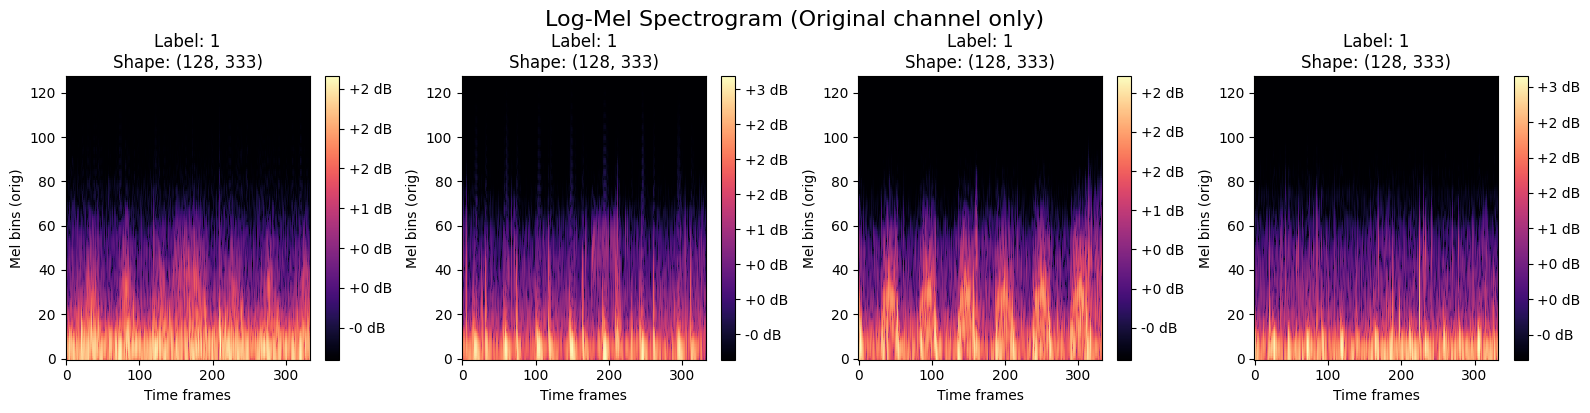

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import h5py
from pathlib import Path

print("=== Debug DataLoader (FINAL FIXED VERSION) ===")
fea_path = str(DATASET_PATH/"logmel_features.h5")

# Load label CSV
label_df = pd.read_csv(DATASET_PATH / 'label.csv')
print("Label CSV columns:", label_df.columns.tolist())

# Sửa filename thành stem
label_df['filename'] = label_df['filename'].apply(lambda x: Path(x).stem)

# Kiểm tra HDF5 keys
with h5py.File(fea_path, 'r') as f:
    print("First 10 HDF5 keys:", list(f.keys())[:10])

# Debug dataset
debug_dataset = HeartSoundDataSet(
    fea_path=fea_path,
    labels=label_df.head(8),
    duration=5,
    training=True,
    delta=True,   # Đang bật delta → 384 mel bins
    norm=True
)

debug_loader = DataLoader(debug_dataset, batch_size=4, shuffle=True, num_workers=0)

for data, target in debug_loader:
    print(f"Batch shape: {data.shape}")
    print(f"Targets: {target.numpy()}")
    print(f"Value range: {data.min().item():.3f} ~ {data.max().item():.3f}")

    # === PHẦN VISUALIZE ĐÃ FIX ===
    plt.figure(figsize=(16, 4))
    for i in range(data.shape[0]):
        plt.subplot(1, 4, i + 1)

        spectrogram = data[i].numpy()  # shape: (384, 333) nếu delta=True, hoặc (128, 333) nếu delta=False

        # Nếu dùng delta → tách ra để chỉ vẽ channel gốc (128 mel bins đầu tiên)
        if spectrogram.shape[0] == 384:  # 3 * 128
            img = spectrogram[:128, :]   # Chỉ lấy phần logmel gốc (channel 0)
        else:
            img = spectrogram            # Không delta → vẽ hết

        plt.imshow(img, aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
        plt.title(f"Label: {target[i].item()}\nShape: {img.shape}")
        plt.xlabel("Time frames")
        plt.ylabel("Mel bins (orig)")
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()

    plt.suptitle("Log-Mel Spectrogram (Original channel only)", fontsize=16, y=1.02)
    plt.show()
    break

=== Debug DataLoader (FINAL FIXED VERSION) ===
Label CSV columns: ['filename', 'label']
First 10 HDF5 keys: ['a0001', 'a0002', 'a0003', 'a0004', 'a0005', 'a0006', 'a0007', 'a0008', 'a0009', 'a0010']
Batch shape: torch.Size([4, 384, 333])
Targets: [1 1 1 1]
Value range: -0.908 ~ 3.283


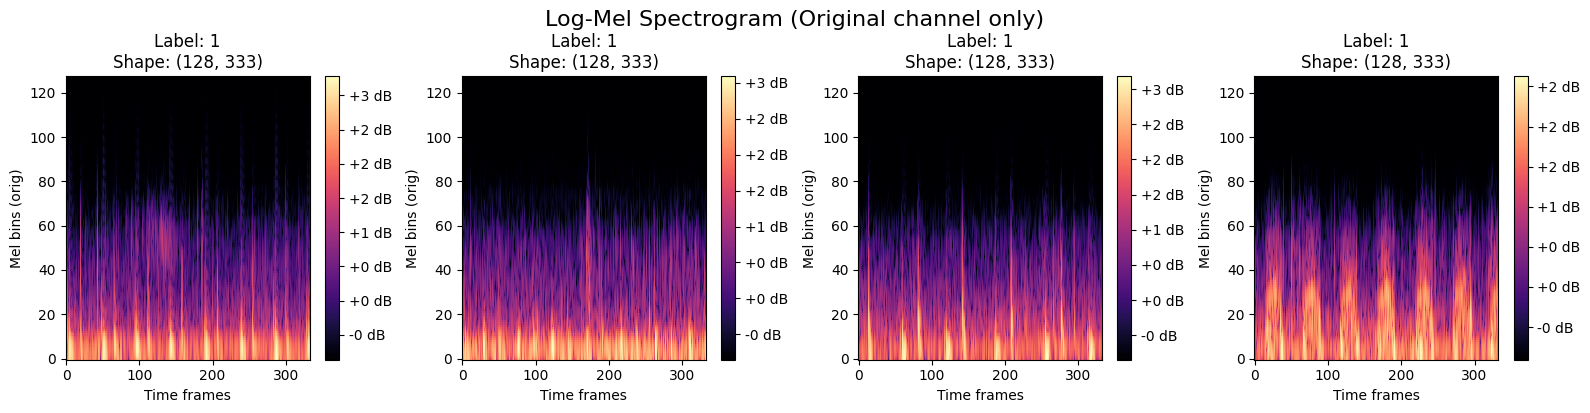

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import h5py
from pathlib import Path

print("=== Debug DataLoader (FINAL FIXED VERSION) ===")
fea_path = str(DATASET_PATH/"logmel_features_validation.h5")

# Load label CSV
label_df = pd.read_csv(DATASET_PATH / 'label_validation.csv')
print("Label CSV columns:", label_df.columns.tolist())

# Sửa filename thành stem
label_df['filename'] = label_df['filename'].apply(lambda x: Path(x).stem)

# Kiểm tra HDF5 keys
with h5py.File(fea_path, 'r') as f:
    print("First 10 HDF5 keys:", list(f.keys())[:10])

# Debug dataset
debug_dataset = HeartSoundDataSet(
    fea_path=fea_path,
    labels=label_df.head(8),
    duration=5,
    training=True,
    delta=True,   # Đang bật delta → 384 mel bins
    norm=True
)

debug_loader = DataLoader(debug_dataset, batch_size=4, shuffle=True, num_workers=0)

for data, target in debug_loader:
    print(f"Batch shape: {data.shape}")
    print(f"Targets: {target.numpy()}")
    print(f"Value range: {data.min().item():.3f} ~ {data.max().item():.3f}")

    # === PHẦN VISUALIZE ĐÃ FIX ===
    plt.figure(figsize=(16, 4))
    for i in range(data.shape[0]):
        plt.subplot(1, 4, i + 1)

        spectrogram = data[i].numpy()  # shape: (384, 333) nếu delta=True, hoặc (128, 333) nếu delta=False

        # Nếu dùng delta → tách ra để chỉ vẽ channel gốc (128 mel bins đầu tiên)
        if spectrogram.shape[0] == 384:  # 3 * 128
            img = spectrogram[:128, :]   # Chỉ lấy phần logmel gốc (channel 0)
        else:
            img = spectrogram            # Không delta → vẽ hết

        plt.imshow(img, aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
        plt.title(f"Label: {target[i].item()}\nShape: {img.shape}")
        plt.xlabel("Time frames")
        plt.ylabel("Mel bins (orig)")
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()

    plt.suptitle("Log-Mel Spectrogram (Original channel only)", fontsize=16, y=1.02)
    plt.show()
    break

# ConfigParser

In [ ]:
# parse_config.py
import os
import logging
from pathlib import Path
from datetime import datetime
import argparse
import collections
import importlib.util

class ConfigParser:
    def __init__(self, config_dict, resume=None, modification=None, run_id=None):
        self._config = config_dict
        self.resume = resume

        # Apply CLI modifications
        if modification:
            for key_path, value in modification.items():
                keys = key_path.split(';')
                d = self._config
                for k in keys[:-1]:
                    d = d[k]
                d[keys[-1]] = value

        # Setup save and log directories
        save_dir = Path(self.config['trainer']['save_dir'])
        exper_name = self.config['name']
        if run_id is None:
            run_id = datetime.now().strftime(r'%m%d_%H%M%S')
        self._save_dir = save_dir / 'models' / exper_name / run_id
        self._log_dir = save_dir / 'log' / exper_name / run_id

        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.log_dir.mkdir(parents=True, exist_ok=True)

        # Optional: setup logging
        # setup_logging(self.log_dir)

    @classmethod
    def from_args(cls, parser, options=None):
        """
        parser: argparse.ArgumentParser đã được add_argument xong
        options: list các CustomArgs để override
        """
        if options is None:
            options = []

        # Parse arguments (an toàn cho cả terminal và notebook)
        args = parser.parse_args()

        # Xử lý device
        if args.device is not None:
            os.environ["CUDA_VISIBLE_DEVICES"] = args.device

        # Xử lý resume
        if args.resume is not None:
            resume = Path(args.resume)
            cfg_fname = resume.parent / 'config.py'  # hoặc .json nếu bạn dùng cả 2
        else:
            resume = None
            assert args.config is not None, "Phải chỉ định -c config.py"
            cfg_fname = Path(args.config)

        # Đọc config từ file .py
        if not cfg_fname.exists():
            raise FileNotFoundError(f"Không tìm thấy config file: {cfg_fname}")

        if cfg_fname.suffix == '.py':
            spec = importlib.util.spec_from_file_location("config_module", cfg_fname)
            config_module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(config_module)
            if not hasattr(config_module, 'config'):
                raise ValueError(f"File {cfg_fname} phải định nghĩa biến 'config'")
            config_dict = config_module.config
        else:
            raise ValueError("Chỉ hỗ trợ file config .py")

        # Parse custom CLI overrides
        CustomArgs = collections.namedtuple('CustomArgs', 'flags type target')
        modification = {}
        for opt in options:
            for flag in opt.flags:
                arg_name = flag.lstrip('-').replace('-', '_')
                if hasattr(args, arg_name) and getattr(args, arg_name) is not None:
                    modification[opt.target] = opt.type(getattr(args, arg_name))

        return cls(config_dict, resume, modification)

    def init_obj(self, name, module, *args, **kwargs):
        module_name = self[name]['type']
        module_args = dict(self[name]['args'])
        module_args.update(kwargs)
        if isinstance(module, dict):
            obj_class = module[module_name]
        else:
            obj_class = getattr(module, module_name)

        return obj_class(*args, **module_args)

    def init_ftn(self, name, module, *args, **kwargs):
        from functools import partial
        module_name = self[name]['type']
        module_args = dict(self[name]['args'])
        module_args.update(kwargs)
        if isinstance(module, dict):
            obj_class = module[module_name]
        else:
            obj_class = getattr(module, module_name)

        return obj_class(*args, **module_args)

    def __getitem__(self, name):
        return self.config[name]

    def get_logger(self, name, verbosity=2):
        logger = logging.getLogger(name)
        logger.setLevel({0: logging.WARNING, 1: logging.INFO, 2: logging.DEBUG}[verbosity])
        return logger

    @property
    def config(self):
        return self._config

    @property
    def save_dir(self):
        return self._save_dir

    @property
    def log_dir(self):
        return self._log_dir

# Logging

In [ ]:
import importlib
from datetime import datetime


class TensorboardWriter():
    def __init__(self, log_dir, logger, enabled):
        self.writer = None
        self.selected_module = ""

        if enabled:
            log_dir = str(log_dir)

            # Retrieve vizualization writer.
            succeeded = False
            for module in ["torch.utils.tensorboard", "tensorboardX"]:
                try:
                    self.writer = importlib.import_module(module).SummaryWriter(log_dir)
                    succeeded = True
                    break
                except ImportError:
                    succeeded = False
                self.selected_module = module

            if not succeeded:
                message = "Warning: visualization (Tensorboard) is configured to use, but currently not installed on " \
                    "this machine. Please install TensorboardX with 'pip install tensorboardx', upgrade PyTorch to " \
                    "version >= 1.1 to use 'torch.utils.tensorboard' or turn off the option in the 'config.json' file."
                logger.warning(message)

        self.step = 0
        self.mode = ''

        self.tb_writer_ftns = {
            'add_scalar', 'add_scalars', 'add_image', 'add_images', 'add_audio',
            'add_text', 'add_histogram', 'add_pr_curve', 'add_embedding'
        }
        self.tag_mode_exceptions = {'add_histogram', 'add_embedding'}
        self.timer = datetime.now()

    def set_step(self, step, mode='train'):
        self.mode = mode
        self.step = step
        if step == 0:
            self.timer = datetime.now()
        else:
            duration = datetime.now() - self.timer
            self.add_scalar('steps_per_sec', 1 / duration.total_seconds())
            self.timer = datetime.now()

    def __getattr__(self, name):
        """
        If visualization is configured to use:
            return add_data() methods of tensorboard with additional information (step, tag) added.
        Otherwise:
            return a blank function handle that does nothing
        """
        if name in self.tb_writer_ftns:
            add_data = getattr(self.writer, name, None)

            def wrapper(tag, data, *args, **kwargs):
                if add_data is not None:
                    # add mode(train/valid) tag
                    if name not in self.tag_mode_exceptions:
                        tag = '{}/{}'.format(tag, self.mode)
                    add_data(tag, data, self.step, *args, **kwargs)
            return wrapper
        else:
            # default action for returning methods defined in this class, set_step() for instance.
            try:
                attr = object.__getattr__(name)
            except AttributeError:
                raise AttributeError("type object '{}' has no attribute '{}'".format(self.selected_module, name))
            return attr

#Loss

In [ ]:
import torch.nn.functional as F


def nll_loss(output, target):
    return F.nll_loss(output, target)

def ce_loss(output, target):
    return F.cross_entropy(output, target)

# Metric

In [ ]:
import torch


def accuracy(output, target):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        assert pred.shape[0] == len(target)
        correct = 0
        correct += torch.sum(pred == target).item()
    return correct / len(target)


def top_k_acc(output, target, k=3):
    with torch.no_grad():
        pred = torch.topk(output, k, dim=1)[1]
        assert pred.shape[0] == len(target)
        correct = 0
        for i in range(k):
            correct += torch.sum(pred[:, i] == target).item()
    return correct / len(target)

# Model


In [ ]:
import torch.nn as nn
import numpy as np
from abc import abstractmethod


class BaseModel(nn.Module):
    """
    Base class for all models
    """
    @abstractmethod
    def forward(self, *inputs):
        """
        Forward pass logic

        :return: Model output
        """
        raise NotImplementedError

    def __str__(self):
        """
        Model prints with number of trainable parameters
        """
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        return super().__str__() + '\nTrainable parameters: {}'.format(params)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from base import BaseModel

# functions of initializing layers
def init_layer(layer):
    """Initialize a Linear or Convolutional layer."""
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)

def init_bn(bn):
    """Initialize a Batchnorm layer."""
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.)

def init_rnn(rnn):
    """init_rnn
    Initialized RNN weights, independent of type GRU/LSTM/RNN
    :param rnn: the rnn model
    """
    for name, param in rnn.named_parameters():
        if 'bias' in name:
            nn.init.constant_(param, 0.0)
        elif 'weight' in name:
            nn.init.xavier_uniform_(param)

def reset_parameters(model):
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            init_layer(module)
        elif isinstance(module, nn.Linear):
            init_layer(module)
        elif isinstance(module, nn.BatchNorm2d):
            init_bn(module)
        elif isinstance(module, nn.LSTM):
            init_rnn(module)


## Simple CNN Block

In [ ]:
class simple_cnn(BaseModel):
    def __init__(self, num_classes = 2, in_channel=1):
        super(simple_cnn, self).__init__()
        self.in_channel = in_channel
        self.conv1 = nn.Conv2d(in_channel,16,3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,3)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(64,32)
        self.output = nn.Linear(32,num_classes)
        self.activate = nn.Softmax()

        self.init_weights()

    def init_weights(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_layer(self.conv3)
        init_layer(self.fc1)
        init_layer(self.output)
        init_bn(self.bn1)
        init_bn(self.bn2)
        init_bn(self.bn3)


    def forward(self,x):
        B, mel_bins, num_frames = x.size()
        x = x.view(B, self.in_channel, -1, num_frames)
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = self.bn1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = self.bn2(x)
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        x = self.bn3(x)
        x = self.pool(x).reshape(x.size(0),-1)
        x = self.fc1(x)
        x = F.dropout(x, p=0.5, training=self.training)
        out = self.output(x)
        out = self.activate(out)
        return out

## Deeper CNN model, VGG like structure

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = in_channels,
                               out_channels = out_channels,
                               kernel_size = (3,3),
                               stride = (1,1),
                               padding = (1,1),
                               bias =False)

        self.conv2 = nn.Conv2d(in_channels = out_channels,
                               out_channels = out_channels,
                               kernel_size = (3,3),
                               stride = (1,1),
                               padding = (1,1),
                               bias = False)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weights()

    def init_weights(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

    def forward(self, input, pool_size=(2, 2), pool_type='max', activation = 'relu'):
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        if activation == 'relu':
            x = F.relu_(self.bn2(self.conv2(x)))
        elif activation == 'sigmoid':
            x = torch.sigmoid(self.bn2(self.conv2(x)))

        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')

        return x

class VGG_11(BaseModel):
    def __init__(self, num_classes, in_channel):
        super(VGG_11, self).__init__()
        self.in_channel = in_channel
        self.bn0 = nn.BatchNorm2d(128)
        self.conv1 = ConvBlock(in_channels=in_channel, out_channels=64)
        self.conv2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv4 = ConvBlock(in_channels=256, out_channels=512)
        self.fc_final = nn.Linear(512, num_classes)
        self.init_weights()

    def init_weights(self):
        init_bn(self.bn0)
        init_layer(self.fc_final)

    def forward(self, input):
        # (batch_size, 3, mel_bins, time_stamps)
        B, mel_bins, num_frames = input.size()
        x = input.view(B, self.in_channel, -1, num_frames)
        x = x.transpose(1, 2)
        x = self.bn0(x)
        x = x.transpose(1,2)

        # (samples_num, channel, mel_bins, time_stamps)
        x = self.conv1(x, pool_size=(2, 2), pool_type='max')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, pool_size=(2, 2), pool_type='max')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, pool_size=(2, 2), pool_type='max')
        x = F.dropout(x, p=0.2, training = self.training)
        x = self.conv4(x, pool_size=(2, 2), pool_type='max')
        x = F.dropout(x, p=0.2, training=self.training)

        output = F.max_pool2d(x, kernel_size=x.shape[2:])
        output = output.view(output.shape[0:2])
        output = F.log_softmax(self.fc_final(output), dim=-1)
        return output


class VGG_13(BaseModel):
    def __init__(self, num_classes, in_channel):
        super(VGG_13, self).__init__()
        self.in_channel = in_channel
        self.bn0 = nn.BatchNorm2d(128)
        self.conv1 = ConvBlock(in_channels=in_channel, out_channels=64)
        self.conv2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv4 = ConvBlock(in_channels=256, out_channels=512)
        self.conv5 = ConvBlock(in_channels=512, out_channels=512)
        self.fc_1 = nn.Linear(512 * 4* 10, 4096)
        self.fc_2 = nn.Linear(4096, 4096)
        self.fc_final = nn.Linear(4096, num_classes)
        self.init_weights()

    def init_weights(self):
        init_bn(self.bn0)
        init_layer(self.fc_final)
        init_layer(self.fc_1)
        init_layer(self.fc_2)

    def forward(self, input):
        # (batch_size, 3, mel_bins, time_stamps)
        B, mel_bins, num_frames = input.size()
        x = input.view(B, self.in_channel, -1, num_frames)
        x = x.transpose(1, 2)
        x = self.bn0(x)
        x = x.transpose(1,2)

        # (samples_num, channel, time_stemps, mel_bins)
        x = self.conv1(x, pool_size=(2, 2), pool_type='max')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, pool_size=(2, 2), pool_type='max')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, pool_size=(2, 2), pool_type='max')
        x = F.dropout(x, p=0.2, training = self.training)
        x = self.conv4(x, pool_size=(2, 2), pool_type='max')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv5(x, pool_size=(2, 2), pool_type='max')
        x = F.dropout(x, p=0.2, training=self.training)
        #output = F.max_pool2d(x, kernel_size=x.shape[2:])
        #output = output.view(output.shape[0:2])
        x = x.view(x.shape[0], -1)
        x = F.relu_(self.fc_1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu_(self.fc_2(x))
        x = F.dropout(x, p=0.5, training=self.training)
        output = F.log_softmax(self.fc_final(x),dim=-1)
        #output = F.log_softmax(self.fc_final(output), dim=-1)
        return output

## RNN - BiLTSM

In [ ]:
class BiLSTM(BaseModel):
    def __init__(self,
                 input_dim=200,
                 hidden_dim=256,
                 num_layers =2,
                 dropout=0.2,
                 num_classes=2,
                 pooling='first',
                 model='lstm',
                 BN=False):
        super(BiLSTM,self).__init__()
        if model == 'lstm':
            self.LSTM = nn.LSTM(input_size=input_dim,
                                hidden_size =hidden_dim,
                                num_layers =num_layers,
                                batch_first =True,
                                dropout=dropout,
                                bidirectional=True)
        elif model == 'gru':
            self.LSTM = nn.GRU(input_size=input_dim,
                               hidden_size =hidden_dim,
                               num_layers =num_layers,
                               batch_first =True,
                               dropout=dropout,
                               bidirectional=True)
        init_rnn(self.LSTM)
        self.BN = BN
        if self.BN:
            self.BatchNorm=nn.BatchNorm1d(hidden_dim*2)

        self.layer_out = nn.Linear(hidden_dim*2,num_classes,bias=False)
        self.pooling=pooling

    def forward(self,x):
        x = x.transpose(2,1) #[Batchsize x Time_frames x Mel_bin]
        x,_ = self.LSTM(x)
        if self.BN:
            x = self.BatchNorm(x.transpose(1,2))
            x = x.transpose(1,2)
        dim =1
        x = self.layer_out(x)  #200,2
        if self.pooling == 'avg':
            x = x.mean(dim)   #average pooling
        elif self.pooling == 'first':
            x = x.select(dim,0)  #first time step
        elif self.pooling == 'last':
            x = x.select(dim,-1)  #first time step
        elif self.pooling == 'max':
            x = x.max(dim)[0]
        elif  self.pooling == 'linear':
            (x**2).sum(dim) / x.sum(dim)
        elif self.pooling == 'exp':
            (x.exp() * x).sum(dim) / x.exp().sum(dim)

        # print(out.shape)
        # out = self.LogSoftmax(out)#the input given is expected to contain log-probabilities. Obtaining log-probabilities in a neural network is easily achieved by adding a LogSoftmax layer in the last layer of your network.
        return x#,A

## CRNN

In [ ]:
class CNN_Encoder(nn.Module):
    def __init__(self, in_channels):
        super(CNN_Encoder, self).__init__()

        self.conv1 = ConvBlock(in_channels=in_channels, out_channels=32)
        self.conv2 = ConvBlock(in_channels=32, out_channels=64)
        self.conv3 = ConvBlock(in_channels=64, out_channels=128)
        self.conv4 = ConvBlock(in_channels=128, out_channels=256)
    def forward(self, input):
        x = input
        x = self.conv1(x, pool_size=(2, 2))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, pool_size=(2, 2))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, pool_size=(2, 2))
        x = F.dropout(x, p=0.2, training = self.training)
        x = self.conv4(x, pool_size=(2, 2))
        x = F.dropout(x, p=0.2, training=self.training)

        return x

class crnn(BaseModel):
    def __init__(self, in_channel,
                 hidden_dim=128,
                 num_layers = 2,
                 dropout = 0.2,
                 pooling = 'first',
                 model='lstm',
                 BN = True,
                 num_classes=2):
        super(crnn,self).__init__()

        self.in_channel = in_channel
        self.bn0 = nn.BatchNorm2d(128)

        self.cnn = CNN_Encoder(in_channels=in_channel)
        self.bilstm = BiLSTM(input_dim=256,
                             hidden_dim=hidden_dim,
                             num_layers =num_layers,
                             dropout =dropout,
                             num_classes=num_classes,
                             pooling=pooling,
                             model=model,
                             BN=BN)


    def forward(self,input):
        if isinstance(input, (tuple, list)):
          input = input[0]
        # (batch_size, 3, mel_bins, time_stamps)
        B, mel_bins, num_frames = input.size()
        x = input.view(B, self.in_channel, -1, num_frames)
        x = x.transpose(1, 2)
        x = self.bn0(x)
        x = x.transpose(1,2)

        x = self.cnn(x)
        x = F.max_pool2d(x,kernel_size=(x.size(-2), 1)) # pool mel dimension
        x = x.squeeze(-2)  # [B x C x Time_frames]
        output = self.bilstm(x)
        return output

# Config

## CNN

In [ ]:
from pathlib import Path

config_cnn = {
    "name": "Physionet_simple_cnn",
    "n_gpu": 1,

    # --------------------------------------------------------
    # Model architecture
    # --------------------------------------------------------
    "arch": {
        "type": "simple_cnn",
        "args": {
            "num_classes": 2,
            "in_channel": 3
        }
    },

    # --------------------------------------------------------
    # Data loader configuration
    # --------------------------------------------------------
    "data_loader": {
        "type": "HeartSoundDataLoader",
        "full_label_csv": str(DATASET_PATH/ "label.csv"),
        "args": {
            # Extracted Log-Mel features directory
            "fea_path": str(DATASET_PATH/"logmel_features.h5"),
            "duration": 5,
            "batch_size": 32,
            "delta": True,
            "norm": True,
            "shuffle": False,
            "validation_split": 0.1,
            "num_workers": 2,
            "label_df": pd.read_csv(str(DATASET_PATH/ "label.csv"))
        }
    },

    # --------------------------------------------------------
    # Optimizer
    # --------------------------------------------------------
    "optimizer": {
        "type": "Adam",
        "args": {
            "lr": 2e-4,
            "weight_decay": 0.0,
            "amsgrad": True
        }
    },

    # --------------------------------------------------------
    # Loss function and metrics
    # --------------------------------------------------------
    "loss": "ce_loss",
    "metrics": [
        "accuracy"
    ],

    # --------------------------------------------------------
    # Learning rate scheduler
    # --------------------------------------------------------
    "lr_scheduler": {
        "type": "StepLR",
        "args": {
            "step_size": 20,
            "gamma": 0.9
        }
    },

    # --------------------------------------------------------
    # Trainer configuration
    # --------------------------------------------------------
    "trainer": {
        "epochs": 120,
        "save_dir": str(PROJECT_PATH / "saved"/"simple_cnn"),
        "save_period": 1,
        "verbosity": 2,
        "monitor": "max val_MAcc",
        "early_stop": 20,
        "tensorboard": True
    }
}


## CRNN

In [ ]:
from pathlib import Path

config_crnn = {
    "name": "Physionet_CRNN",
    "n_gpu": 1,

    # --------------------------------------------------------
    # Model architecture
    # --------------------------------------------------------
    "arch": {
        "type": "crnn",
        "args": {
            "in_channel": 1,
            "hidden_dim": 256,
            "num_layers": 2,
            "dropout": 0.2,
            "pooling": "first",
            "model": "lstm",
            "BN": True,
            "num_classes": 2
        }
    },

    # --------------------------------------------------------
    # Data loader configuration
    # --------------------------------------------------------
    "data_loader": {
        "type": "HeartSoundDataLoader",
        "full_label_csv": str(DATASET_PATH/ "label.csv"),
        "args": {
            # Extracted Log-Mel feature directory
            "fea_path": str(DATASET_PATH/"logmel_features.h5"),
            "duration": 5,
            "batch_size": 64,
            "norm": True,
            "shuffle": False,
            "validation_split": 0.1,
            "num_workers": 2,
            "label_df": pd.read_csv(str(DATASET_PATH/ "label.csv"))
        }
    },

    # --------------------------------------------------------
    # Optimizer
    # --------------------------------------------------------
    "optimizer": {
        "type": "Adam",
        "args": {
            "lr": 2e-4,
            "weight_decay": 0.0,
            "amsgrad": True
        }
    },

    # --------------------------------------------------------
    # Loss and metrics
    # --------------------------------------------------------
    "loss": "ce_loss",
    "metrics": [
        "accuracy"
    ],

    # --------------------------------------------------------
    # Learning rate scheduler
    # --------------------------------------------------------
    "lr_scheduler": {
        "type": "StepLR",
        "args": {
            "step_size": 20,
            "gamma": 0.9
        }
    },

    # --------------------------------------------------------
    # Trainer configuration
    # --------------------------------------------------------
    "trainer": {
        "epochs": 120,
        "save_dir": str(PROJECT_PATH / "saved" / "CRNN"),
        "save_period": 1,
        "verbosity": 2,
        "monitor": "max val_MAcc",
        "early_stop": 20,
        "tensorboard": True
    }
}


## LTSM

In [ ]:
from pathlib import Path

config_lstm = {
    "name": "Physionet_LSTM",
    "n_gpu": 1,

    # --------------------------------------------------------
    # Model architecture
    # --------------------------------------------------------
    "arch": {
        "type": "BiLSTM",
        "args": {
            "input_dim": 128,
            "hidden_dim": 256,
            "num_layers": 2,
            "dropout": 0.2,
            "pooling": "first",
            "model": "lstm",
            "BN": True,
            "num_classes": 2
        }
    },

    # --------------------------------------------------------
    # Data loader configuration
    # --------------------------------------------------------
    "data_loader": {
        "type": "HeartSoundDataLoader",
        "full_label_csv": str(DATASET_PATH/ "label.csv"),
        "args": {
            # Extracted Log-Mel feature directory
            "fea_path": str(DATASET_PATH/"logmel_features.h5"),
            "duration": 5,
            "batch_size": 32,
            "norm": True,
            "shuffle": False,
            "validation_split": 0.1,
            "num_workers": 2,
            "label_df": pd.read_csv(str(DATASET_PATH/ "label.csv"))
        }
    },

    # --------------------------------------------------------
    # Optimizer
    # --------------------------------------------------------
    "optimizer": {
        "type": "Adam",
        "args": {
            "lr": 2e-4,
            "weight_decay": 0.0,
            "amsgrad": True
        }
    },

    # --------------------------------------------------------
    # Loss and metrics
    # --------------------------------------------------------
    "loss": "ce_loss",
    "metrics": [
        "accuracy"
    ],

    # --------------------------------------------------------
    # Learning rate scheduler
    # --------------------------------------------------------
    "lr_scheduler": {
        "type": "StepLR",
        "args": {
            "step_size": 20,
            "gamma": 0.9
        }
    },

    # --------------------------------------------------------
    # Trainer configuration
    # --------------------------------------------------------
    "trainer": {
        "epochs": 120,
        "save_dir": str(PROJECT_PATH / "saved" / "LSTM"),
        "save_period": 1,
        "verbosity": 2,

        "monitor": "max val_MAcc",
        "early_stop": 20,

        "tensorboard": True
    }
}


## VGG

In [ ]:
from pathlib import Path

config_vgg = {
    "name": "Physionet_VGG11",
    "n_gpu": 1,

    # --------------------------------------------------------
    # Model architecture
    # --------------------------------------------------------
    "arch": {
        "type": "VGG_11",
        "args": {
            "num_classes": 2,
            "in_channel": 3
        }
    },

    # --------------------------------------------------------
    # Data loader configuration
    # --------------------------------------------------------
    "data_loader": {
        "type": "HeartSoundDataLoader",
        "full_label_csv": str(DATASET_PATH/ "label.csv"),
        "args": {
            # Extracted Log-Mel feature directory
            "fea_path": str(DATASET_PATH/"logmel_features.h5"),
            "duration": 5,
            "batch_size": 32,
            "delta": True,
            "norm": True,
            "shuffle": False,
            "validation_split": 0.1,
            "num_workers": 2,
            "label_df": pd.read_csv(str(DATASET_PATH/ "label.csv"))
        }
    },

    # --------------------------------------------------------
    # Optimizer
    # --------------------------------------------------------
    "optimizer": {
        "type": "Adam",
        "args": {
            "lr": 2e-4,
            "weight_decay": 0.0,
            "amsgrad": True
        }
    },

    # --------------------------------------------------------
    # Loss and metrics
    # --------------------------------------------------------
    "loss": "ce_loss",
    "metrics": [
        "accuracy"
    ],

    # --------------------------------------------------------
    # Learning rate scheduler
    # --------------------------------------------------------
    "lr_scheduler": {
        "type": "StepLR",
        "args": {
            "step_size": 20,
            "gamma": 0.9
        }
    },

    # --------------------------------------------------------
    # Trainer configuration
    # --------------------------------------------------------
    "trainer": {
        "epochs": 200,
        "save_dir": str(PROJECT_PATH / "saved" / "VGG11"),
        "save_period": 1,
        "verbosity": 2,

        "monitor": "max val_accuracy",
        "early_stop": 20,

        "tensorboard": True
    }
}


# Training

In [ ]:
def prepare_device(n_gpu_use):
    """
    setup GPU device if available. get gpu device indices which are used for DataParallel
    """
    n_gpu = torch.cuda.device_count()
    if n_gpu_use > 0 and n_gpu == 0:
        print("Warning: There\'s no GPU available on this machine,"
              "training will be performed on CPU.")
        n_gpu_use = 0
    if n_gpu_use > n_gpu:
        print(f"Warning: The number of GPU\'s configured to use is {n_gpu_use}, but only {n_gpu} are "
              "available on this machine.")
        n_gpu_use = n_gpu
    device = torch.device('cuda:0' if n_gpu_use > 0 else 'cpu')
    list_ids = list(range(n_gpu_use))
    return device, list_ids

In [ ]:
class MetricTracker:
    def __init__(self, *keys, writer=None):
        self.writer = writer
        self._data = pd.DataFrame(index=keys, columns=['total', 'counts', 'average'])
        self.reset()

    def reset(self):
        for col in self._data.columns:
            self._data[col].values[:] = 0

    def update(self, key, value, n=1):
        if self.writer is not None:
            self.writer.add_scalar(key, value)
        df = self._data

        df.loc[key, "total"] += value * n
        df.loc[key, "counts"] += n
        df.loc[key, "average"] = df.loc[key, "total"] / df.loc[key, "counts"]


    def avg(self, key):
        return self._data.average[key]

    def result(self):
        return dict(self._data.average)

In [ ]:
def setup_logging(save_dir, log_config='logger/logger_config.json', default_level=logging.INFO):
    """
    Setup logging configuration
    """
    log_config = Path(log_config)
    if log_config.is_file():
        config = read_json(log_config)
        # modify logging paths based on run config
        for _, handler in config['handlers'].items():
            if 'filename' in handler:
                handler['filename'] = str(save_dir / handler['filename'])

        logging.config.dictConfig(config)
    else:
        print("Warning: logging configuration file is not found in {}.".format(log_config))
        logging.basicConfig(level=default_level)
import importlib
from datetime import datetime


class TensorboardWriter():
    def __init__(self, log_dir, logger, enabled):
        self.writer = None
        self.selected_module = ""

        if enabled:
            log_dir = str(log_dir)

            # Retrieve vizualization writer.
            succeeded = False
            for module in ["torch.utils.tensorboard", "tensorboardX"]:
                try:
                    self.writer = importlib.import_module(module).SummaryWriter(log_dir)
                    succeeded = True
                    break
                except ImportError:
                    succeeded = False
                self.selected_module = module

            if not succeeded:
                message = "Warning: visualization (Tensorboard) is configured to use, but currently not installed on " \
                    "this machine. Please install TensorboardX with 'pip install tensorboardx', upgrade PyTorch to " \
                    "version >= 1.1 to use 'torch.utils.tensorboard' or turn off the option in the 'config.json' file."
                logger.warning(message)

        self.step = 0
        self.mode = ''

        self.tb_writer_ftns = {
            'add_scalar', 'add_scalars', 'add_image', 'add_images', 'add_audio',
            'add_text', 'add_histogram', 'add_pr_curve', 'add_embedding'
        }
        self.tag_mode_exceptions = {'add_histogram', 'add_embedding'}
        self.timer = datetime.now()

    def set_step(self, step, mode='train'):
        self.mode = mode
        self.step = step
        if step == 0:
            self.timer = datetime.now()
        else:
            duration = datetime.now() - self.timer
            self.add_scalar('steps_per_sec', 1 / duration.total_seconds())
            self.timer = datetime.now()

    def __getattr__(self, name):
        """
        If visualization is configured to use:
            return add_data() methods of tensorboard with additional information (step, tag) added.
        Otherwise:
            return a blank function handle that does nothing
        """
        if name in self.tb_writer_ftns:
            add_data = getattr(self.writer, name, None)

            def wrapper(tag, data, *args, **kwargs):
                if add_data is not None:
                    # add mode(train/valid) tag
                    if name not in self.tag_mode_exceptions:
                        tag = '{}/{}'.format(tag, self.mode)
                    add_data(tag, data, self.step, *args, **kwargs)
            return wrapper
        else:
            # default action for returning methods defined in this class, set_step() for instance.
            try:
                attr = object.__getattr__(name)
            except AttributeError:
                raise AttributeError("type object '{}' has no attribute '{}'".format(self.selected_module, name))
            return attr

In [ ]:
import torch
from abc import abstractmethod
from numpy import inf

class BaseTrainer:
    """
    Base class for all trainers
    """
    def __init__(self, model, criterion, metric_ftns, optimizer, config):
        self.config = config
        self.logger = config.get_logger('trainer', config['trainer']['verbosity'])

        self.model = model
        self.criterion = criterion
        self.metric_ftns = metric_ftns
        self.optimizer = optimizer

        cfg_trainer = config['trainer']
        self.epochs = cfg_trainer['epochs']
        self.save_period = cfg_trainer['save_period']
        self.monitor = cfg_trainer.get('monitor', 'off')

        # configuration to monitor model performance and save best
        if self.monitor == 'off':
            self.mnt_mode = 'off'
            self.mnt_best = 0
        else:
            self.mnt_mode, self.mnt_metric = self.monitor.split()
            assert self.mnt_mode in ['min', 'max']

            self.mnt_best = inf if self.mnt_mode == 'min' else -inf
            self.early_stop = cfg_trainer.get('early_stop', inf)
            if self.early_stop <= 0:
                self.early_stop = inf

        self.start_epoch = 1

        self.checkpoint_dir = config.save_dir

        self.history = {
            "epoch": [],
            "train_loss": [],
            "train_accuracy": [],
            "val_loss": [],
            "val_accuracy": [],
            "val_f1": []
        }

        self.history_path = Path(self.checkpoint_dir) / "metrics.csv"

        # setup visualization writer instance
        self.writer = TensorboardWriter(config.log_dir, self.logger, cfg_trainer['tensorboard'])

        if config.resume is not None:
            self._resume_checkpoint(config.resume)

    @abstractmethod
    def _train_epoch(self, epoch):
        """
        Training logic for an epoch

        :param epoch: Current epoch number
        """
        raise NotImplementedError

    def train(self):
        """
        Full training logic
        """
        not_improved_count = 0
        for epoch in range(self.start_epoch, self.epochs + 1):
            result = self._train_epoch(epoch)

            # save logged informations into log dict
            log = {'epoch': epoch}
            log.update(result)

            # ===== GHI METRICS SAU MỖI EPOCH =====
            self.history["epoch"].append(epoch)
            self.history["train_loss"].append(log.get("loss"))
            self.history["train_accuracy"].append(log.get("accuracy"))
            self.history["val_loss"].append(log.get("val_loss"))
            self.history["val_accuracy"].append(log.get("val_accuracy"))
            self.history["val_f1"].append(log.get("val_F1_score"))

            pd.DataFrame(self.history).to_csv(self.history_path, index=False)

            # print logged informations to the screen
            for key, value in log.items():
                self.logger.info('    {:15s}: {}'.format(str(key), value))

            # evaluate model performance according to configured metric, save best checkpoint as model_best
            best = False
            if self.mnt_mode != 'off':
                try:
                    # check whether model performance improved or not, according to specified metric(mnt_metric)
                    improved = (self.mnt_mode == 'min' and log[self.mnt_metric] <= self.mnt_best) or \
                               (self.mnt_mode == 'max' and log[self.mnt_metric] >= self.mnt_best)
                except KeyError:
                    self.logger.warning("Warning: Metric '{}' is not found. "
                                        "Model performance monitoring is disabled.".format(self.mnt_metric))
                    self.mnt_mode = 'off'
                    improved = False

                if improved:
                    self.mnt_best = log[self.mnt_metric]
                    not_improved_count = 0
                    best = True
                else:
                    not_improved_count += 1

                if not_improved_count > self.early_stop:
                    self.logger.info("Validation performance didn\'t improve for {} epochs. "
                                     "Training stops.".format(self.early_stop))
                    break

            if best:
                self._save_best_model(epoch)

    def _save_checkpoint(self, epoch, save_best=False):
        """
        Saving checkpoints

        :param epoch: current epoch number
        :param log: logging information of the epoch
        :param save_best: if True, rename the saved checkpoint to 'model_best.pth'
        """
        arch = type(self.model).__name__
        state = {
            'arch': arch,
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'monitor_best': self.mnt_best,
            'config': self.config
        }
        filename = str(self.checkpoint_dir / 'checkpoint-epoch{}.pth'.format(epoch))
        torch.save(state, filename)
        self.logger.info("Saving checkpoint: {} ...".format(filename))
        if save_best:
            best_path = str(self.checkpoint_dir / 'model_best.pth')
            torch.save(state, best_path)
            self.logger.info("Saving current best: model_best.pth ...")

    def _resume_checkpoint(self, resume_path):
        """
        Resume from saved checkpoints

        :param resume_path: Checkpoint path to be resumed
        """
        resume_path = str(resume_path)
        self.logger.info("Loading checkpoint: {} ...".format(resume_path))
        checkpoint = torch.load(resume_path)
        self.start_epoch = checkpoint['epoch'] + 1
        self.mnt_best = checkpoint['monitor_best']

        # load architecture params from checkpoint.
        if checkpoint['config']['arch'] != self.config['arch']:
            self.logger.warning("Warning: Architecture configuration given in config file is different from that of "
                                "checkpoint. This may yield an exception while state_dict is being loaded.")
        self.model.load_state_dict(checkpoint['state_dict'])

        # load optimizer state from checkpoint only when optimizer type is not changed.
        if checkpoint['config']['optimizer']['type'] != self.config['optimizer']['type']:
            self.logger.warning("Warning: Optimizer type given in config file is different from that of checkpoint. "
                                "Optimizer parameters not being resumed.")
        else:
            self.optimizer.load_state_dict(checkpoint['optimizer'])

        self.logger.info("Checkpoint loaded. Resume training from epoch {}".format(self.start_epoch))

    def _save_best_model(self, epoch):
      """
      Save only the best model according to monitoring metric
      """
      arch = type(self.model).__name__
      state = {
          'arch': arch,
          'epoch': epoch,
          'state_dict': self.model.state_dict(),
          'optimizer': self.optimizer.state_dict(),
          'monitor_best': self.mnt_best,
          'config': self.config
      }

      best_path = self.checkpoint_dir / 'model_best.pth'
      torch.save(state, best_path)

      self.logger.info(
          f"Saving new best model at epoch {epoch}: model_best.pth"
      )


In [ ]:
from itertools import repeat

def inf_loop(data_loader):
    ''' wrapper function for endless data loader. '''
    for loader in repeat(data_loader):
        yield from loader

In [ ]:
class Trainer(BaseTrainer):
    """
    Trainer class
    """
    def __init__(self, model, criterion, metric_ftns, optimizer, config, device,
                 data_loader, valid_data_loader=None, lr_scheduler=None, len_epoch=None):
        super().__init__(model, criterion, metric_ftns, optimizer, config)
        self.config = config
        self.device = device
        self.data_loader = data_loader
        if len_epoch is None:
            # epoch-based training
            self.len_epoch = len(self.data_loader)
        else:
            # iteration-based training
            self.data_loader = inf_loop(data_loader)
            self.len_epoch = len_epoch
        self.valid_data_loader = valid_data_loader
        self.do_validation = self.valid_data_loader is not None
        self.lr_scheduler = lr_scheduler
        self.log_step = int(np.sqrt(data_loader.batch_size))

        self.train_metrics = MetricTracker('loss', *[m.__name__ for m in self.metric_ftns], writer=self.writer)
        self.valid_metrics = MetricTracker('loss',*[m.__name__ for m in self.metric_ftns],
                                           'sensitivity', 'specificity', 'MAcc', 'F1_score',
                                           writer = self.writer)


    def _train_epoch(self, epoch):
        """
        Training logic for an epoch

        :param epoch: Integer, current training epoch.
        :return: A log that contains average loss and metric in this epoch.
        """
        self.model.train()
        self.train_metrics.reset()
        for batch_idx, (data, target) in enumerate(self.data_loader):
            data, target = data.to(self.device), target.to(self.device)

            self.optimizer.zero_grad()
            output = self.model(data.float())
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()

            self.writer.set_step((epoch - 1) * self.len_epoch + batch_idx)
            self.train_metrics.update('loss', loss.item())
            for met in self.metric_ftns:
                self.train_metrics.update(met.__name__, met(output, target))

            if batch_idx % self.log_step == 0:
                self.logger.debug('Train Epoch: {} {} Loss: {:.6f}'.format(
                    epoch,
                    self._progress(batch_idx),
                    loss.item()))
                #self.writer.add_image('input', make_grid(data.cpu(), nrow=8, normalize=True))

            if batch_idx == self.len_epoch:
                break
        log = self.train_metrics.result()

        if self.do_validation:
            val_log = self._valid_epoch(epoch)
            log.update(**{'val_'+k : v for k, v in val_log.items()})

        if self.lr_scheduler is not None:
            self.lr_scheduler.step()
        return log

    def _valid_epoch(self, epoch):
        """
        Validate after training an epoch

        :param epoch: Integer, current training epoch.
        :return: A log that contains information about validation
        """
        self.model.eval()
        self.valid_metrics.reset()
        val_pred_pos = 0
        val_pred_neg = 0
        val_condition_pos = 0
        val_condition_neg = 0
        val_TP = 0
        val_TN = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(self.valid_data_loader):
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data.float())
                loss = self.criterion(output, target)

                _,indices = torch.max(output, 1)

                pred_pos_idx = [i for i, x in enumerate(indices) if x == 0]
                condition_pos_idx = [i for i, x in enumerate(target) if x == 0]
                pred_neg_idx = [i for i, x in enumerate(indices) if x == 1]
                condition_neg_idx = [i for i, x in enumerate(target) if x == 1]

                val_pred_pos += len(pred_pos_idx)
                val_condition_pos += len(condition_pos_idx)
                val_pred_neg += len(pred_neg_idx)
                val_condition_neg += len(condition_neg_idx)
                val_TP += len([x for x in pred_pos_idx if x in condition_pos_idx])
                val_TN += len([x for x in pred_neg_idx if x in condition_neg_idx])
                correct = (indices == target).float()
                val_correct += torch.sum(correct).item()
                val_total += target.shape[0]

                self.writer.set_step((epoch - 1) * len(self.valid_data_loader) + batch_idx, 'valid')
                self.valid_metrics.update('loss', loss.item())
                for met in self.metric_ftns:
                    self.valid_metrics.update(met.__name__, met(output, target))
                #self.writer.add_image('input', make_grid(data.cpu(), nrow=8, normalize=True))

        sensitivity = val_TP / val_condition_pos
        specificity = val_TN / val_condition_neg
        MAcc= (sensitivity + specificity) / 2
        if val_pred_pos == 0:
            precision = 0
            F1_score = 0
        else:
            precision = val_TP / val_pred_pos
            F1_score = 2 * (precision*sensitivity)/(precision+sensitivity)

        self.valid_metrics.update('sensitivity', sensitivity)
        self.valid_metrics.update('specificity', specificity)
        self.valid_metrics.update('MAcc',MAcc)
        self.valid_metrics.update('F1_score', F1_score)

        # add histogram of model parameters to the tensorboard
        for name, p in self.model.named_parameters():
            self.writer.add_histogram(name, p, bins='auto')
        return self.valid_metrics.result()

    def _progress(self, batch_idx):
        base = '[{}/{} ({:.0f}%)]'
        if hasattr(self.data_loader, 'n_samples'):
            current = batch_idx * self.data_loader.batch_size
            total = self.data_loader.n_samples
        else:
            current = batch_idx
            total = self.len_epoch
        return base.format(current, total, 100.0 * current / total)

## Simple Train

In [ ]:
#current_config = config_cnn
current_config = config_crnn
#current_config = config_lstm
#current_config = config_vgg

In [ ]:
import os
import argparse
import collections
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

def main(config):

# Tạo ConfigParser từ biến config hiện tại
  config_parser = ConfigParser(config)

  # Train chính thức
  data_loader = config_parser.init_obj('data_loader', globals())  # hoặc import module phù hợp
  valid_data_loader = data_loader.split_validation()

  model = config_parser.init_obj('arch', globals())
  print(model)

  device, device_ids = prepare_device(config_parser['n_gpu'])
  model = model.to(device)
  if len(device_ids) > 1:
      model = torch.nn.DataParallel(model, device_ids=device_ids)

  criterion = ce_loss  # hoặc getattr(...)
  metrics = [accuracy]

  optimizer = config_parser.init_obj('optimizer', torch.optim, filter(lambda p: p.requires_grad, model.parameters()))
  lr_scheduler = config_parser.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

  trainer = Trainer(
      model=model,
      criterion=criterion,
      metric_ftns=metrics,
      optimizer=optimizer,
      config=config_parser,
      device=device,
      data_loader=data_loader,
      valid_data_loader=valid_data_loader,
      lr_scheduler=lr_scheduler
  )

  trainer.train()

  base_dir = (Path(config_parser['trainer']['save_dir'])/ "models"/ config_parser['name'])

  if not base_dir.exists():
    print("Models directory was not found.")
    return

  # Lấy run (timestamp) mới nhất
  latest_run = max(base_dir.iterdir(), key=os.path.getmtime)

  best_model_path = latest_run / "model_best.pth"

  if best_model_path.exists():
    print("\n=== HOÀN THÀNH TRAINING ===")
    print("Model tốt nhất được lưu tại:")
    print(best_model_path)
  else:
    print("The file 'model_best.pth' was not found.")

  metrics_path = Path(config_parser.save_dir) / "metrics.csv"

  if metrics_path.exists():
    df = pd.read_csv(metrics_path)
    epochs = df["epoch"]
  else:
    print("The file 'metrics.csv' was not found. Unable to display training results.")

  # ===== LOSS =====
  plt.figure(figsize=(6,4))
  plt.plot(epochs, df["train_loss"], label="Training Loss", marker="o")
  plt.plot(epochs, df["val_loss"], label="Validation Loss", marker="s")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training and Validation Loss")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(latest_run / "loss_curve.png", dpi=300)
  plt.close()

  # ===== ACCURACY =====
  plt.figure(figsize=(6,4))
  plt.plot(epochs, df["train_accuracy"], label="Training Accuracy", marker="o")
  plt.plot(epochs, df["val_accuracy"], label="Validation Accuracy", marker="s")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Training and Validation Accuracy")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(latest_run / "accuracy_curve.png", dpi=300)
  plt.close()

  # ===== F1-SCORE =====
  plt.figure(figsize=(6,4))
  plt.plot(epochs, df["val_f1"], label="Validation F1-score", marker="^")
  plt.xlabel("Epoch")
  plt.ylabel("F1-score")
  plt.title("Validation F1-score across epochs")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(latest_run / "f1_curve.png", dpi=300)
  plt.close()

  print("\nĐã lưu biểu đồ: loss_curve.png, accuracy_curve.png, f1_curve.png")

  for name in ["loss_curve.png", "accuracy_curve.png", "f1_curve.png"]:
    img_path = latest_run / name

    if not img_path.exists():
        print(f"Not Found {img_path}")
        continue

    img = Image.open(img_path)
    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(name.replace("_", " ").replace(".png", ""))
    plt.show()

# Test

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import pandas as pd

def test_model(config, best_model_path, validation_fea_path, validation_label_csv):
    config_parser = ConfigParser(config)
    device, _ = prepare_device(config_parser['n_gpu'])

    # Khởi tạo model từ config (đảm bảo architecture đúng)
    model = config_parser.init_obj('arch', globals())
    model = model.to(device)

    # === LOAD CHỈ STATE_DICT - AN TOÀN, KHÔNG CẦN WHITELIST ===
    try:
        # Cách 1: Dùng weights_only=True (mặc định từ PT 2.6), chỉ load weights
        checkpoint = torch.load(best_model_path, map_location=device, weights_only=True)
        model.load_state_dict(checkpoint)  # checkpoint ở đây chỉ là state_dict
        print("Loaded model weights with weights_only=True (safe mode)")
    except Exception as e1:
        print(f"weights_only=True failed: {e1}")
        try:
            # Cách 2: Tắt weights_only (chỉ dùng nếu bạn tin tưởng file)
            checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
            model.load_state_dict(checkpoint['state_dict'])
            print("Loaded with weights_only=False (full checkpoint)")
        except Exception as e2:
            print(f"Cả hai cách đều thất bại: {e2}")
            return

    model.eval()

    print("\n=== MODEL ARCHITECTURE ===")
    print(model)
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nSố tham số huấn luyện được: {trainable_params:,}")

    # === Xác định input shape từ config ===
    delta = config['data_loader']['args'].get('delta', False)
    height = 384 if delta else 128
    channels = 3 if delta else 1
    time_frames = 333

    # === Kiểm tra forward với input giả ===
    print("\n=== KIỂM TRA FORWARD PASS ===")
    try:
        with torch.no_grad():
            dummy_input = torch.randn(2, channels * height, time_frames).to(device)
            output = model(dummy_input)
            print(f"Input shape: (B, {channels * height}, {time_frames})")
            print(f"Output shape: {output.shape} → OK")
    except Exception as e:
        print(f"Forward lỗi: {e}")

    # === Load validation data ===
    if not Path(validation_label_csv).exists() or not Path(validation_fea_path).exists():
        print("Không tìm thấy file validation → bỏ qua đánh giá")
        return

    validation_label_df = pd.read_csv(validation_label_csv)
    validation_label_df['filename'] = validation_label_df['filename'].apply(lambda x: Path(x).stem)

    validation_dataset = HeartSoundDataSet(
        fea_path=validation_fea_path,
        labels=validation_label_df,
        duration=config['data_loader']['args']['duration'],
        training=False,
        delta=delta,
        norm=config['data_loader']['args'].get('norm', True)
    )

    print("\n=== DEBUG: SAMPLE FEATURES ===")
    for i in range(min(5, len(validation_dataset))):
        fea, lab = validation_dataset[i]
        print(f"Sample {i}: shape = {fea.shape}, label = {lab.item()}")

    # Tắt pin_memory trên CPU
    pin_memory = (device.type == 'cuda')

    validation_dataloader = DataLoader(
        validation_dataset,
        batch_size=config['data_loader']['args']['batch_size'],
        shuffle=False,
        num_workers=config['data_loader']['args'].get('num_workers', 2),
        pin_memory=pin_memory
    )

    criterion = ce_loss

    print("\n=== ĐÁNH GIÁ TRÊN TẬP VALIDATION RIÊNG ===")
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    val_TP = val_TN = val_pred_pos = val_condition_pos = 0

    with torch.no_grad():
        for data, target in validation_dataloader:
            data, target = data.to(device).float(), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, 1)
            total_correct += (pred == target).sum().item()
            total_samples += target.size(0)

            pred_pos_idx = (pred == 0)      # class 0 = abnormal (positive)
            condition_pos_idx = (target == 0)

            val_TP += (pred_pos_idx & condition_pos_idx).sum().item()
            val_TN += ((pred == 1) & (target == 1)).sum().item()
            val_pred_pos += pred_pos_idx.sum().item()
            val_condition_pos += condition_pos_idx.sum().item()

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    sensitivity = val_TP / val_condition_pos if val_condition_pos > 0 else 0
    specificity = val_TN / (total_samples - val_condition_pos) if (total_samples - val_condition_pos) > 0 else 0
    MAcc = (sensitivity + specificity) / 2
    precision = val_TP / val_pred_pos if val_pred_pos > 0 else 0
    F1_score = 2 * precision * sensitivity / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    val_log = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'MAcc': MAcc,
        'F1_score': F1_score
    }

    print("\nKết quả đánh giá:")
    for k, v in val_log.items():
        print(f"    {k}: {v:.4f}")

    metrics_path = Path(best_model_path).parent / "test_on_validation_set_metrics.csv"
    pd.DataFrame([val_log]).to_csv(metrics_path, index=False)
    print(f"\nĐã lưu kết quả tại: {metrics_path}")

crnn(
  (bn0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn): CNN_Encoder(
    (conv1): ConvBlock(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): ConvBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stri

DEBUG:trainer:Train Epoch: 1 [0/73 (0%)] Loss: 0.790444
DEBUG:trainer:Train Epoch: 1 [8/73 (11%)] Loss: 0.843440
DEBUG:trainer:Train Epoch: 1 [16/73 (22%)] Loss: 0.617092
DEBUG:trainer:Train Epoch: 1 [24/73 (33%)] Loss: 0.591758
DEBUG:trainer:Train Epoch: 1 [32/73 (44%)] Loss: 0.515924
DEBUG:trainer:Train Epoch: 1 [40/73 (55%)] Loss: 0.498479
DEBUG:trainer:Train Epoch: 1 [48/73 (66%)] Loss: 0.374905
DEBUG:trainer:Train Epoch: 1 [56/73 (77%)] Loss: 0.465226
DEBUG:trainer:Train Epoch: 1 [64/73 (88%)] Loss: 0.349142
DEBUG:trainer:Train Epoch: 1 [72/73 (99%)] Loss: 0.294022
INFO:trainer:    epoch          : 1
INFO:trainer:    loss           : 0.5259539780959691
INFO:trainer:    accuracy       : 0.7519691780821918
INFO:trainer:    val_loss       : 0.3055742060144742
INFO:trainer:    val_accuracy   : 0.84375
INFO:trainer:    val_sensitivity: 0.9097744360902256
INFO:trainer:    val_specificity: 0.6379310344827587
INFO:trainer:    val_MAcc       : 0.7738527352864921
INFO:trainer:    val_F1_sco


=== HOÀN THÀNH TRAINING ===
Model tốt nhất được lưu tại:
/content/drive/MyDrive/AutomaticHeartSoundClassification-main/saved/CRNN/models/Physionet_CRNN/0108_105831/model_best.pth

Đã lưu biểu đồ: loss_curve.png, accuracy_curve.png, f1_curve.png


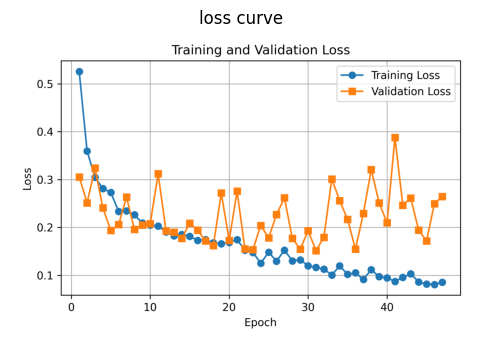

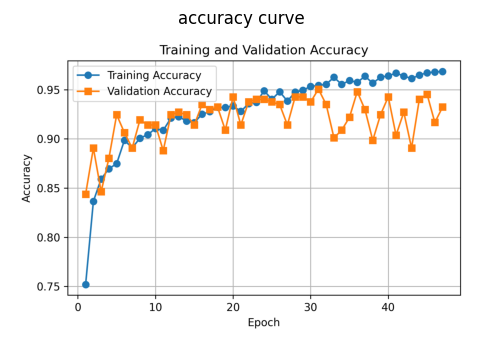

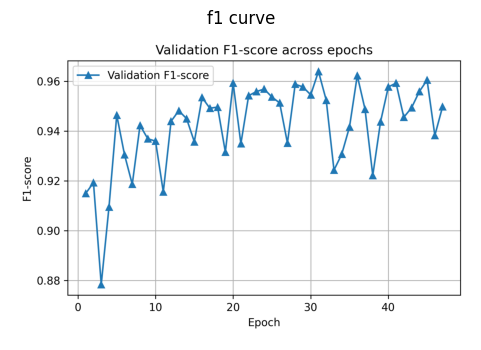

weights_only=True failed: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.ConfigParser was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.ConfigParser])` or the `torch.serialization.safe_globals([__main__.ConfigParser])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accept

In [ ]:
if __name__ == "__main__":
    # Train model với config hiện tại
    main(current_config)

    # Sau khi train xong, tự động test trên tập validation riêng (nếu có file)
    base_dir = Path(current_config['trainer']['save_dir']) / "models" / current_config['name']
    if base_dir.exists():
        latest_run = max(base_dir.iterdir(), key=os.path.getmtime)
        best_model_path = latest_run / "model_best.pth"

        validation_fea_path = str(DATASET_PATH / "logmel_features_validation.h5")
        validation_label_csv = str(DATASET_PATH / "label_validation.csv")  # Đảm bảo file này tồn tại!

        if Path(validation_fea_path).exists() and Path(validation_label_csv).exists():
            test_model(current_config, best_model_path, validation_fea_path, validation_label_csv)
        else:
            print("Không tìm thấy file validation .h5 hoặc label_validation.csv → Bỏ qua phần test.")

        size_bytes = os.path.getsize(best_model_path)
        size_mb = size_bytes / (1024 * 1024)

        print(f"Model size: {size_mb:.2f} MB")

    else:
        print("Không tìm thấy thư mục saved models.")